# Sentiment Analysis on IMDb Film Reviews

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Overview](#overview)
* [4. Exploratory Data Analysis](#eda)
* [5. Preprocessing](#prep)
	* [5.1. Define Evaluation Procedure](#1)
	* [5.2. Normalization](#2)
	* [5.3. Train/Test Split](#3)
* [6. Model Training](#train)
	* [6.1. Constant Model](#61)
	* [6.2. NLTK LR](#62)
	* [6.3. spaCy](#63)
	* [6.4. BERT](#64)
* [7. Model Review](#eval)
	* [7.1. Model 1c - NLTK TF-IDF LR](#71)
	* [7.2. Model 2c1 - spaCy TF-IDF LR](#72)
	* [7.3. Model 2c2 - spaCy TF-IDF LGBMRegressor](#73)
	* [7.4. Model 3a - BERT LR](#74)
* [8. General Conclusion](#end)

## 1. Introduction <a id='intro'></a>

### 1.1. Project Description

Film Junky Union, a new community for classic film enthusiasts, is developing a system to filter and categorize film reviews. The goal is to train a model that can automatically detect negative reviews. You will use a dataset of IMDb film reviews with polarity labels to create a model that can classify reviews as positive or negative.

### 1.2. Objectives

Create a machine learning model to classify reviews sentiment with minimum F1 score of 0.85.

### 1.3. Data Description

The data is stored in the imdb_reviews.tsv file.

The data was obtained from Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Here is the description for the selected columns:
* review: text of the review
* pos: target, '0' for negative and '1' for positive
* ds_part: 'train'/'test' for the train/test part of the dataset

There are other columns in the dataset.

### 1.4. Method

The steps taken in this research are:
1. Understanding data
2. Data preprocessing
3. Exploratory Data Analysis
4. Model Training
5. Model Testing
6. Conclusion

[back to table of contents](#back)

## 2. Initiation <a id='init'></a>

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics

import re
import spacy 
import nltk
from nltk.corpus import stopwords

import torch
import transformers

from tqdm.auto import tqdm
import warnings
import time

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# To provide better graphics
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# to use progress_apply, read more on https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [4]:
# turn off warnings.
warnings.filterwarnings('ignore')

In [5]:
# settting random seed
np.random.seed(0)

[back to table of contents](#back)

## 3. Data Overview <a id='overview'></a>

In [6]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
df_reviews.head(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336


In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [9]:
df_reviews.query('votes.isna()')

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [10]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [11]:
df_reviews.duplicated().sum()

0

There are duplicated rows or redundant columns. However 2 missing values and some values are stored as '\N'. Some of the missing value because there are no data regarding those columns.

[back to table of contents](#back)

## 4. Exploratory Data Analysis <a id='eda'></a>

Check number of movies and reviews over years.

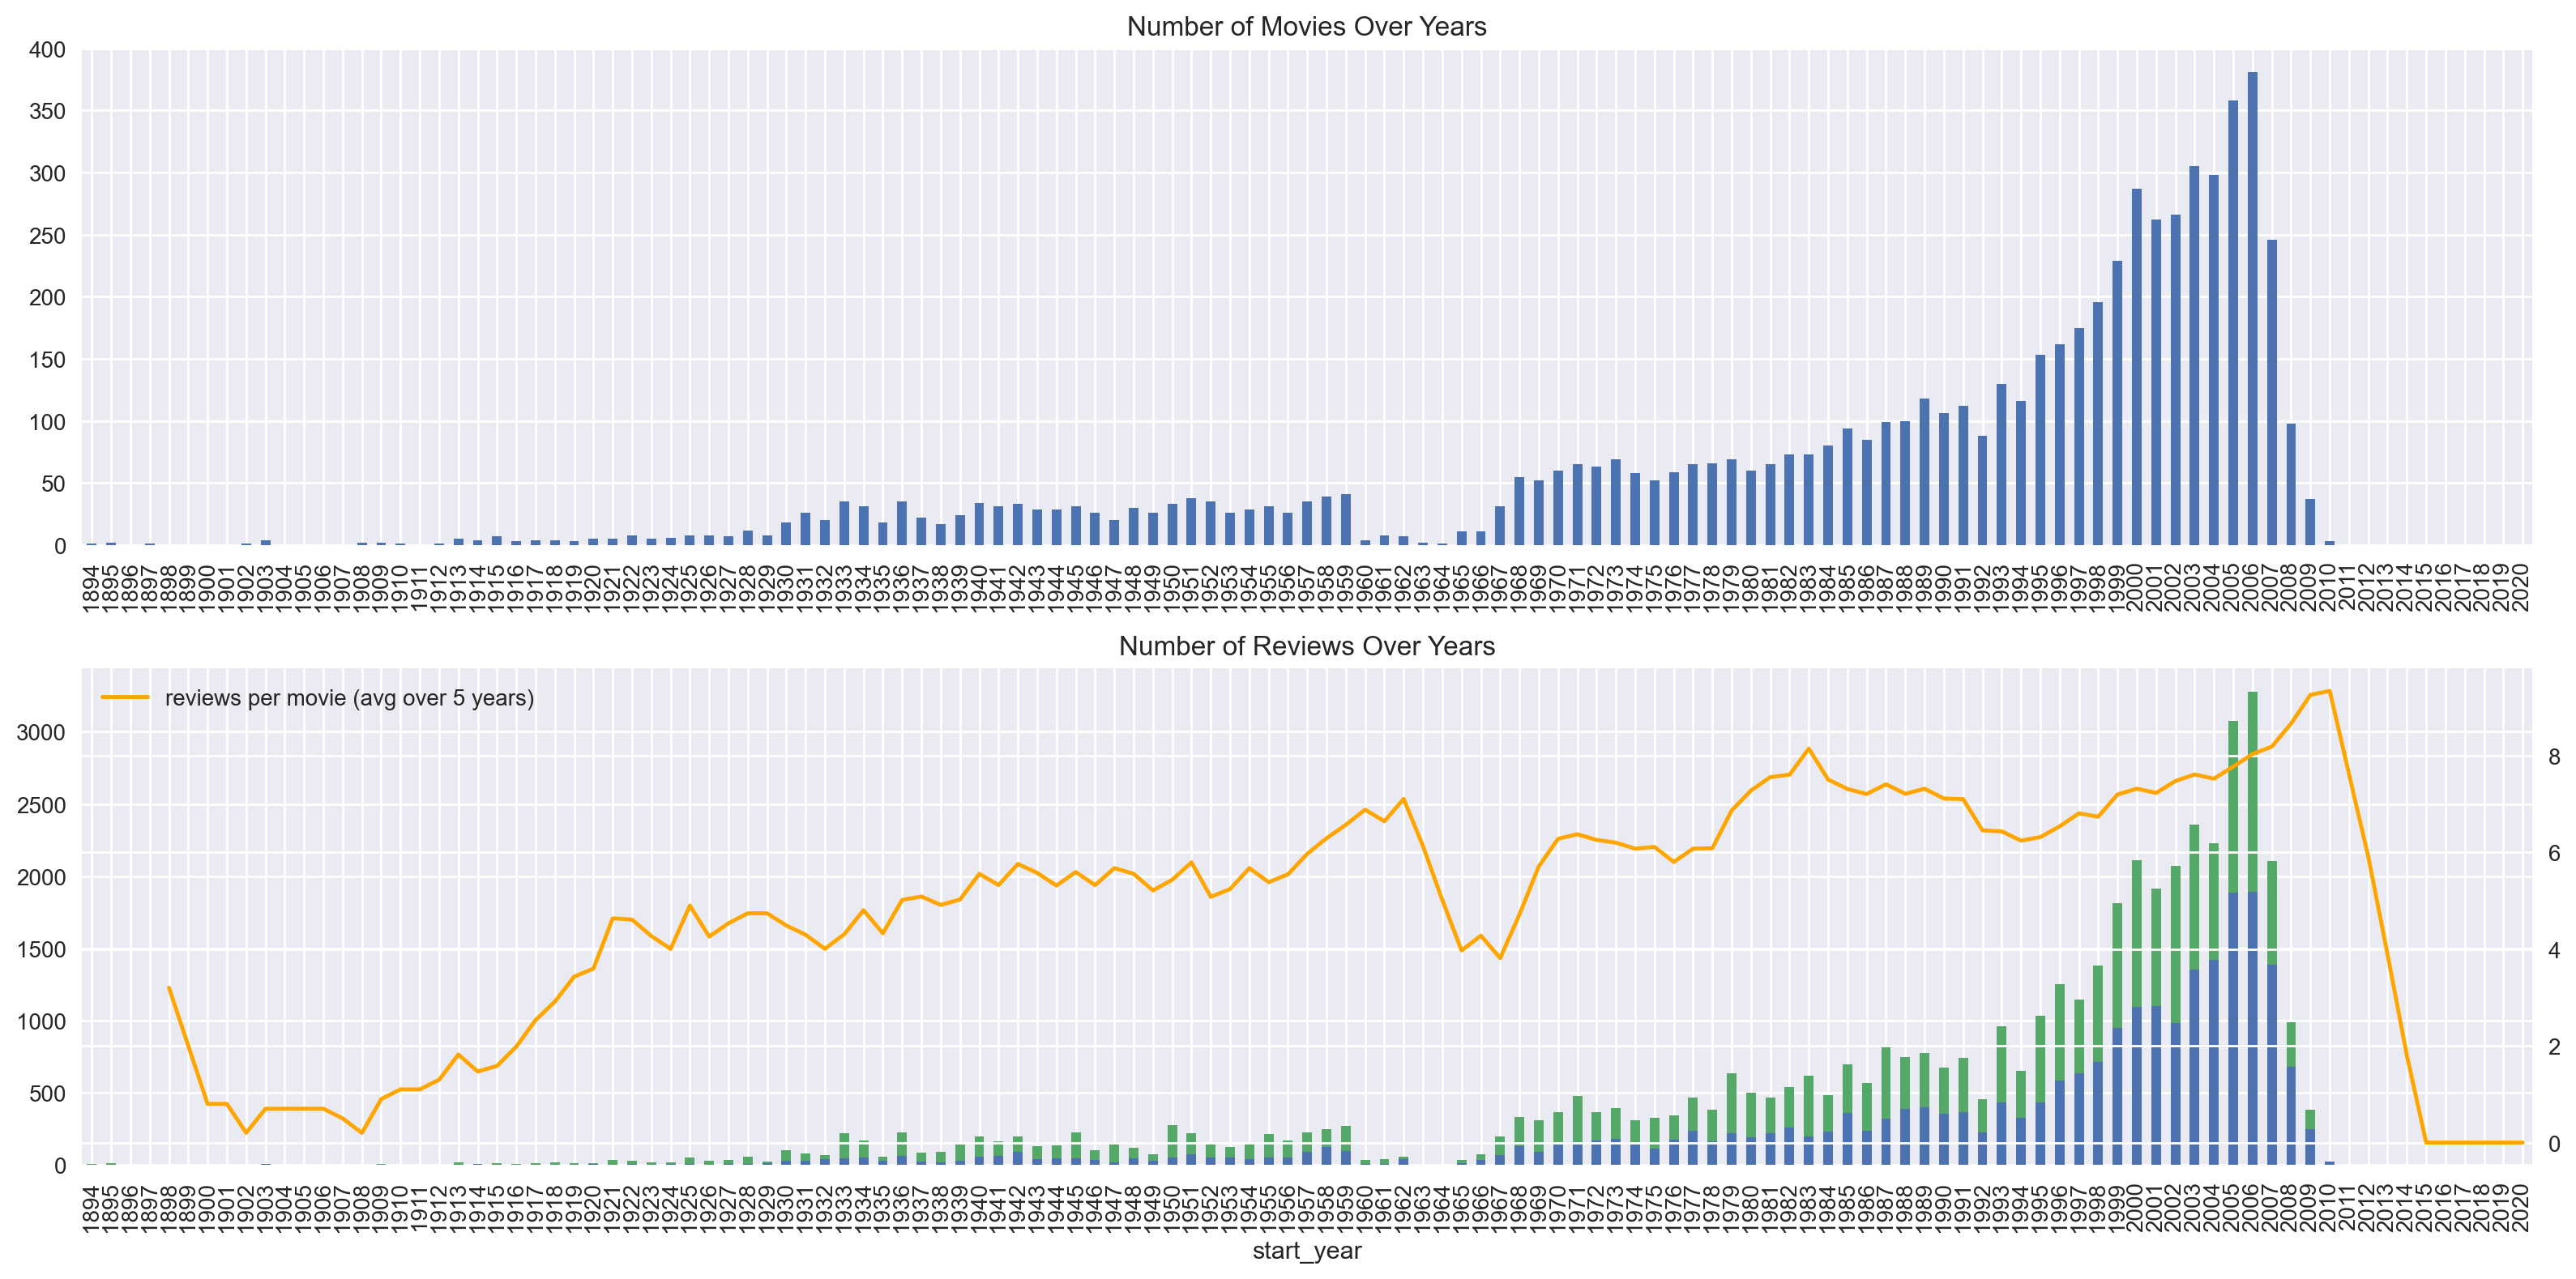

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label='#review  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc=2)

ax.set_title('Number of Reviews Over Years') 

fig.tight_layout()

The number of movies is increasing steadily over the years until 2006 when it reaches around 380 movies then it drops afterwards. The number of positive and negative reviews are also increasing in the same trend.

Check number of reviews per movie distribution.

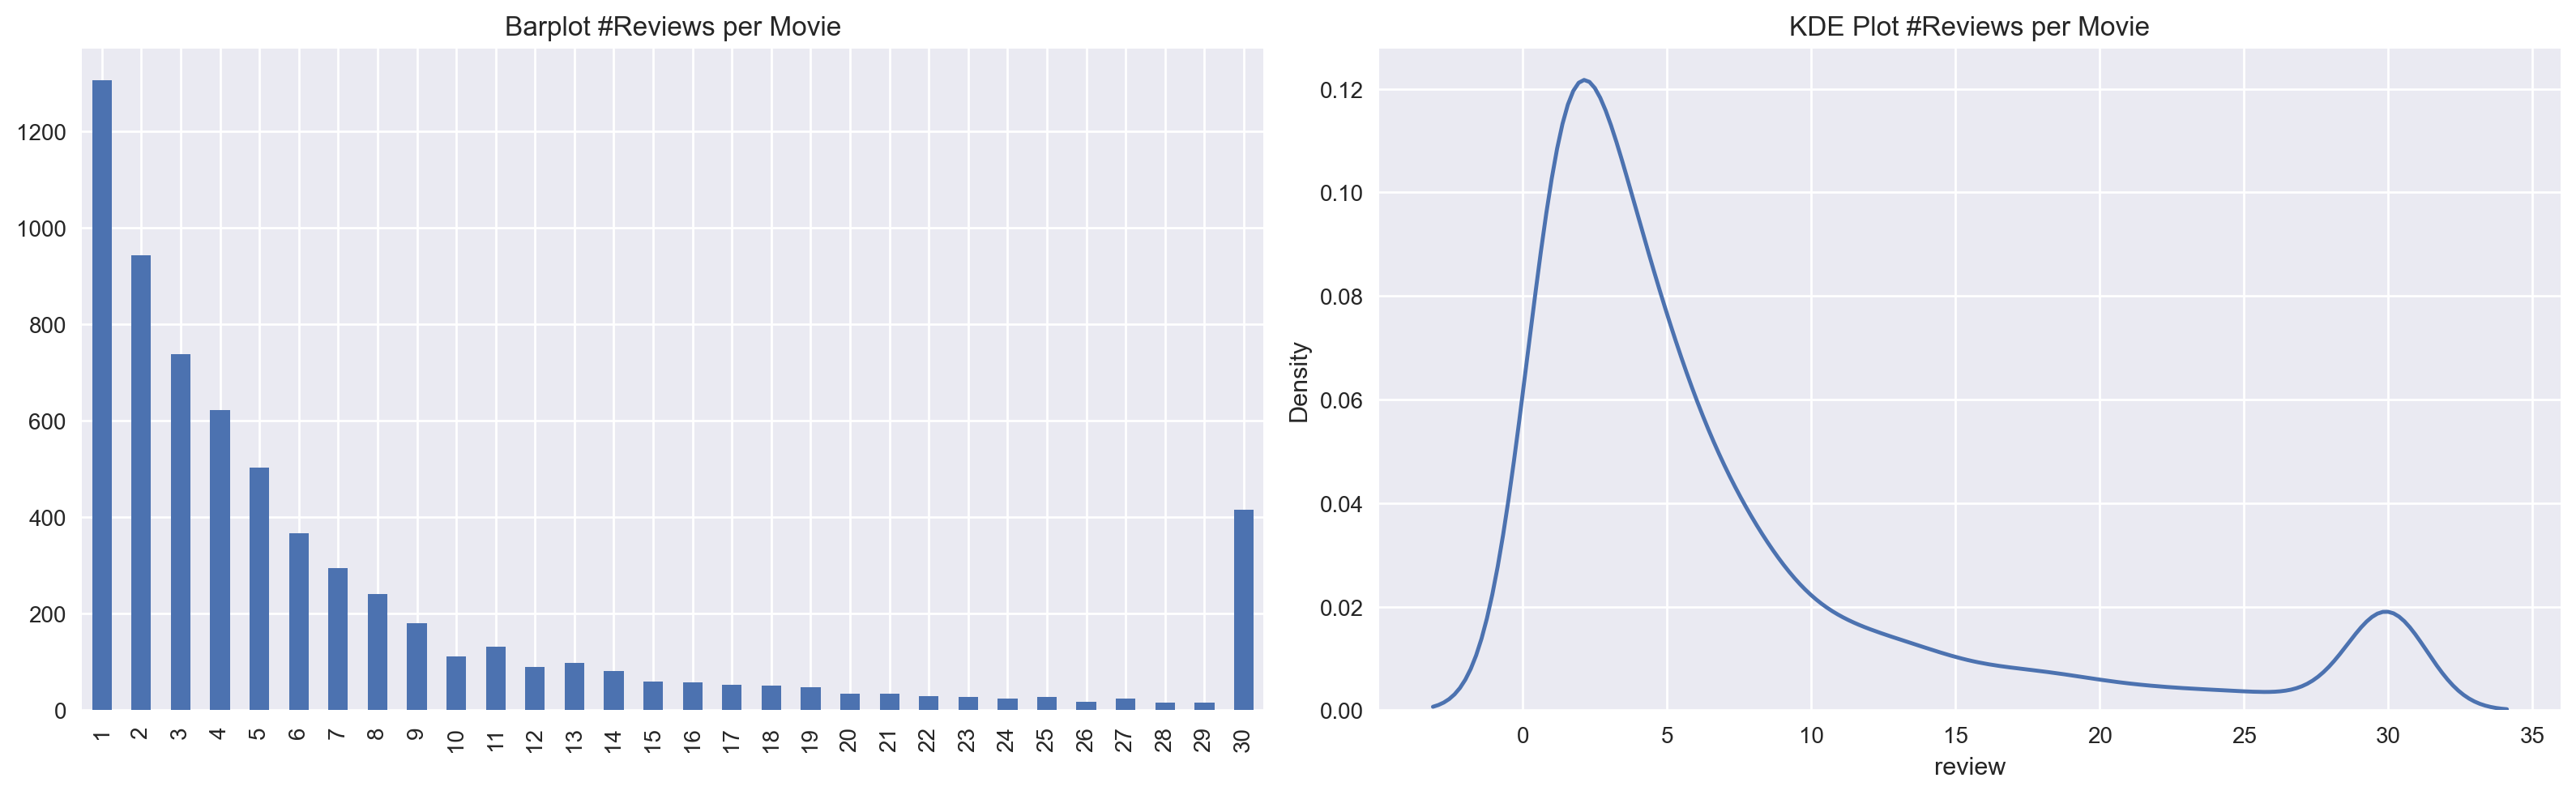

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Barplot #Reviews per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot #Reviews per Movie') 

fig.tight_layout()

The number of reviews per movie distribution decrease exponentially except for 30 reviews per movie.

In [14]:
df_reviews['ds_part'].value_counts(normalize=True)

train    0.502757
test     0.497243
Name: ds_part, dtype: float64

The proportion of train and test set are balanced.

In [15]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

The proportion of positive and negative reviews are balanced.

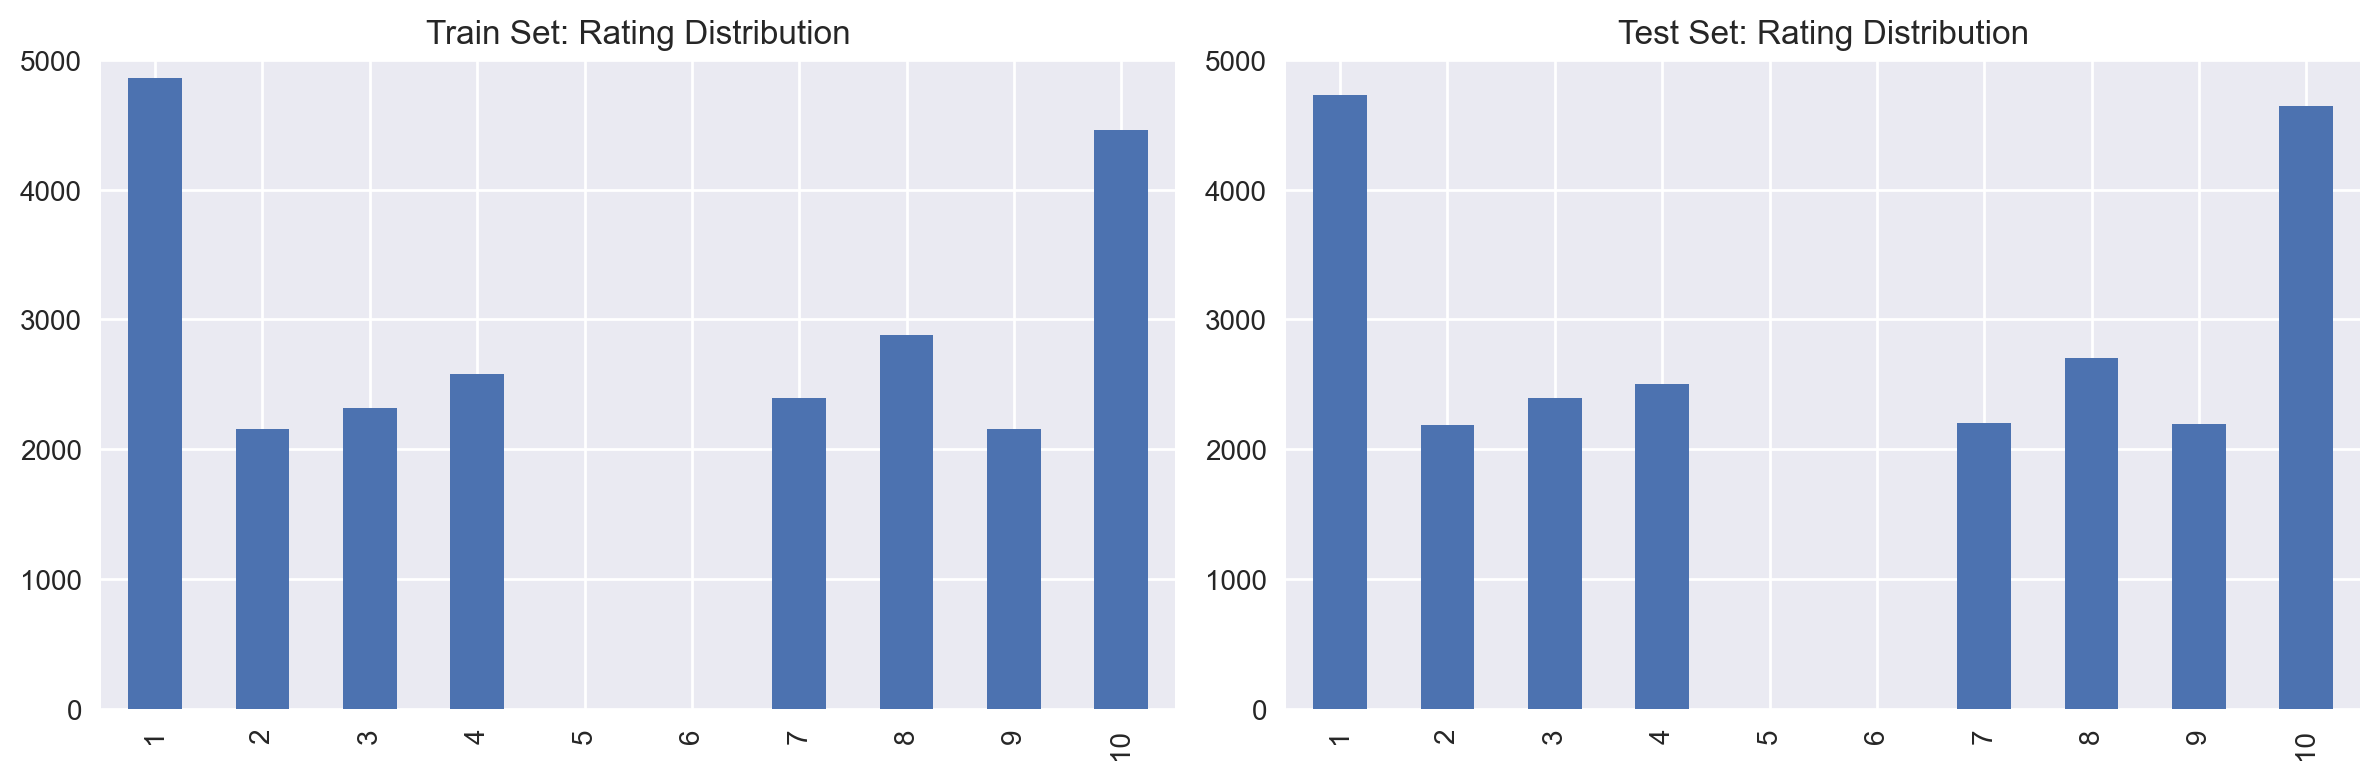

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train Set: Rating Distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test Set: Rating Distribution')

fig.tight_layout()

The rating distributions are similar for train and test sets.

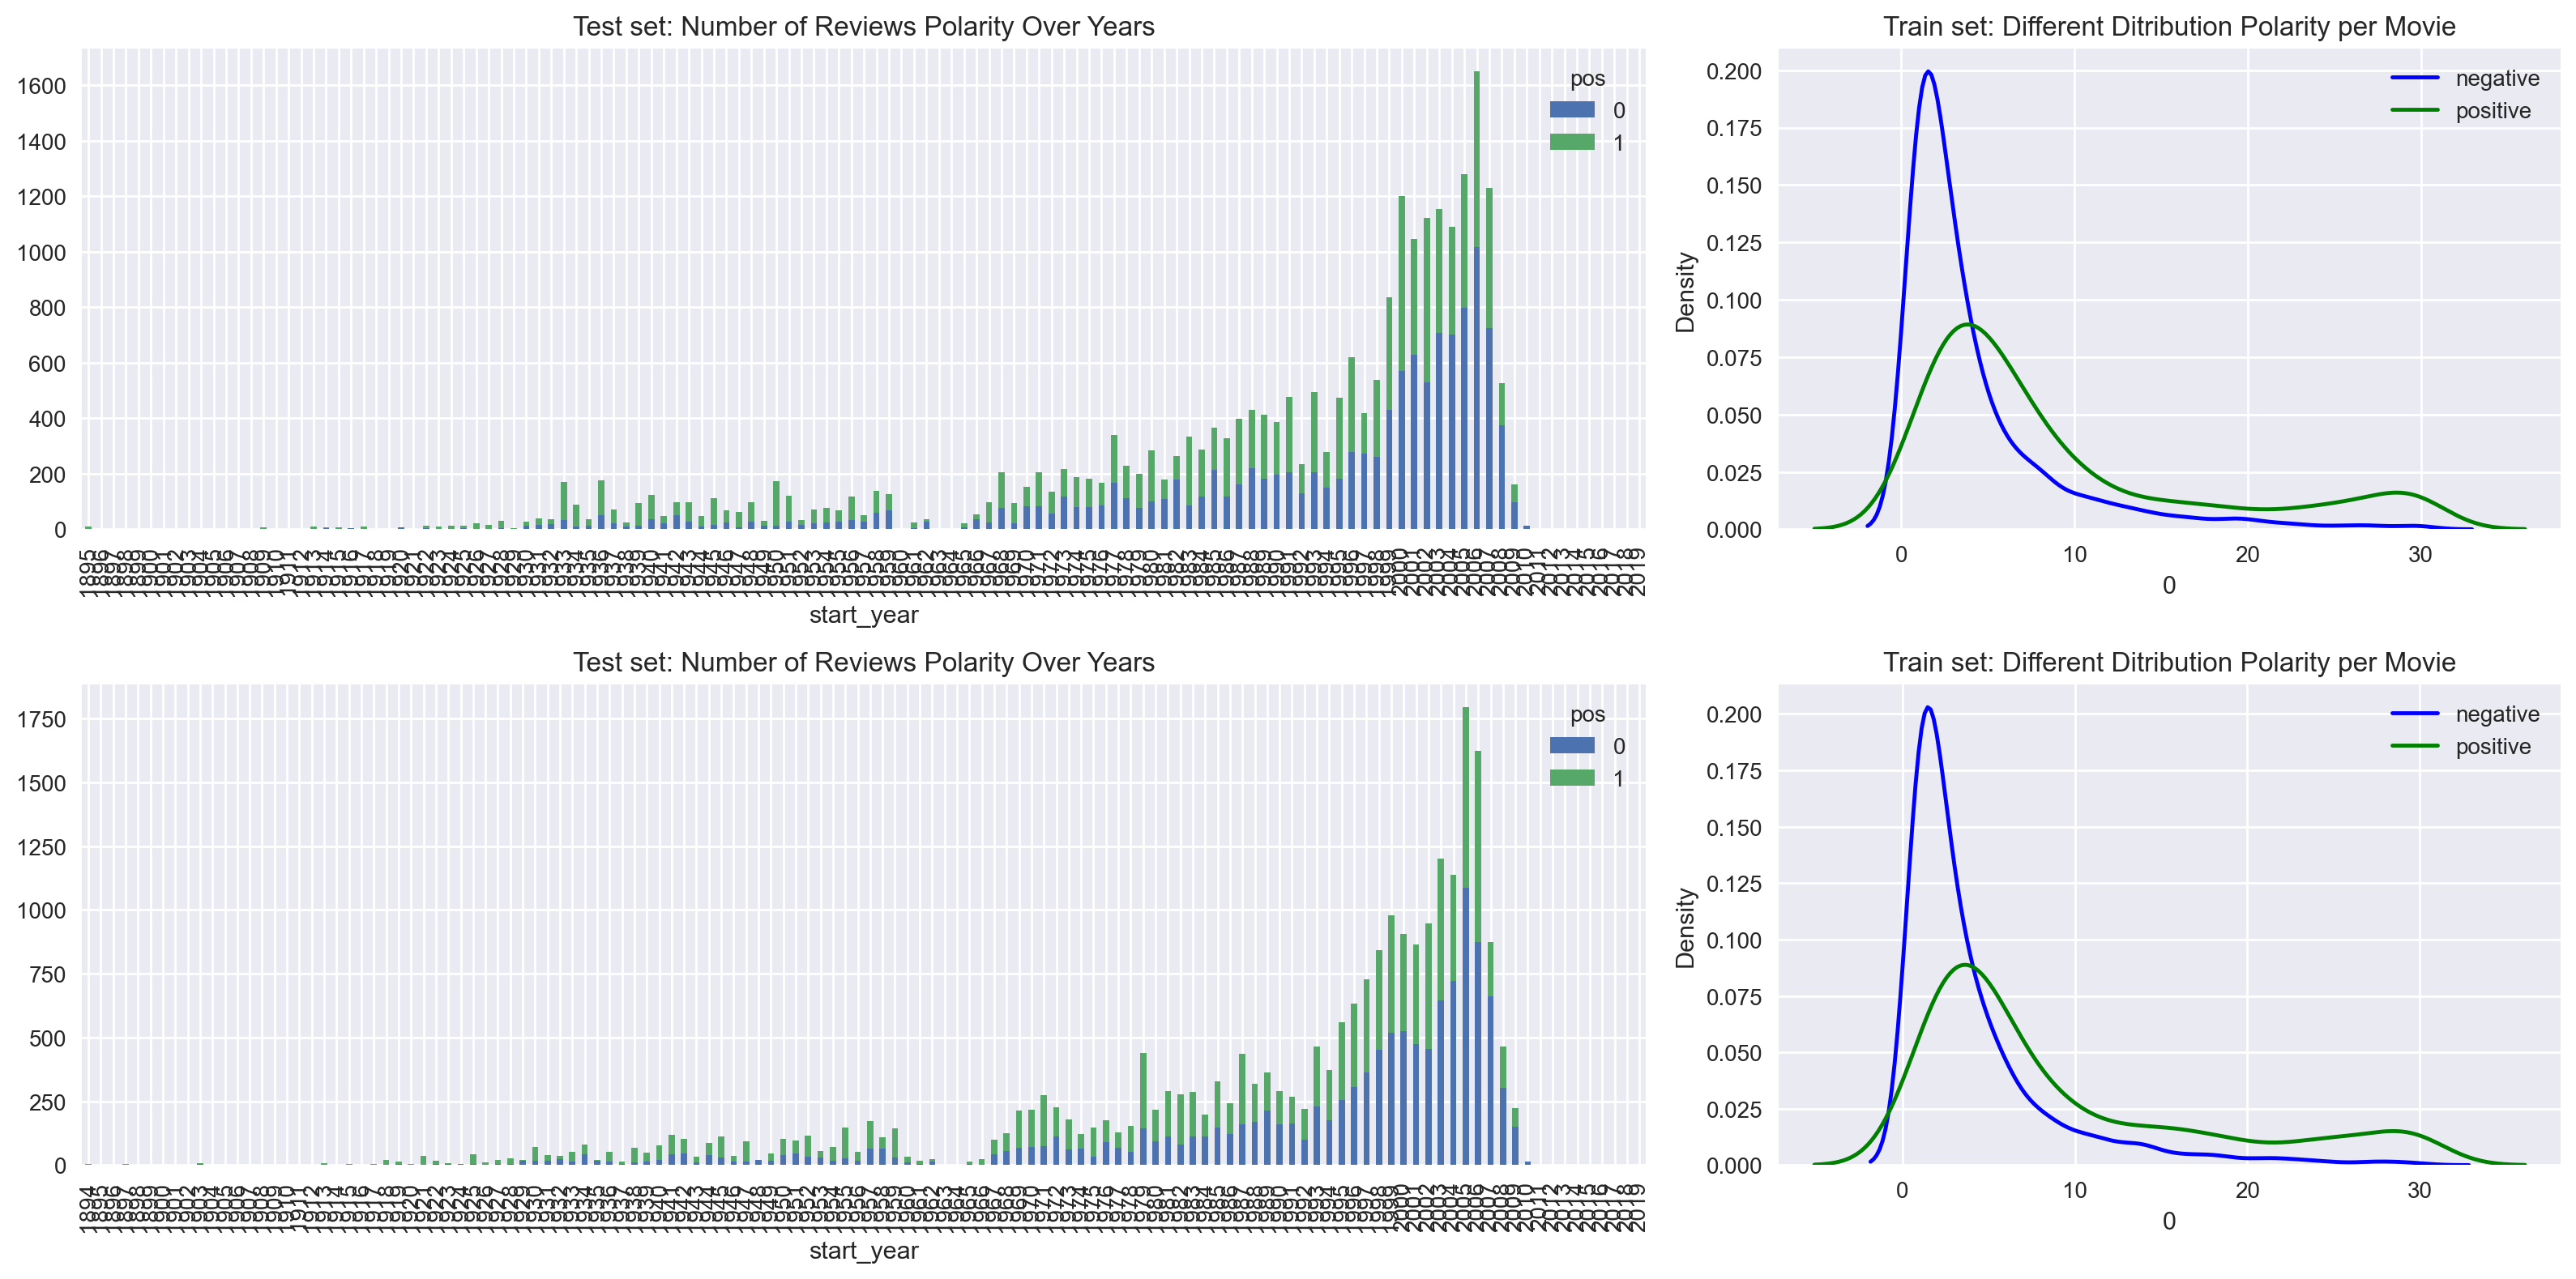

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: Number of Reviews Polarity Over Years')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: Different Ditribution Polarity per Movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: Number of Reviews Polarity Over Years')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: Different Ditribution Polarity per Movie')

fig.tight_layout()

The distribution of positive and negative reviews are similar in both train and test set. It is most frequent to see about 1 negative review and 4 positive reviews in a movie.

[back to table of contents](#back)

## 5. Preprocessing <a id='prep'>

### 5.1. Define Evaluation Procedure <a id='1'>

Arrange evaluation procedure for all models.

In [18]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
             
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Akurasi'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Akurasi', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

[back to table of contents](#back)

### 5.2. Normalization <a id='2'></a>

Assume all models only process text in lowercase without digits, punctuation marks, etc.

In [19]:
def clear_text(text):
    pattern = r"[^a-z]"
    a = re.sub(pattern, " ", text)
    return " ".join(a.split())

In [20]:
df_reviews['review_norm'] = df_reviews['review'].str.lower()
df_reviews['review_norm'] = df_reviews['review_norm'].progress_apply(clear_text)

  0%|          | 0/47331 [00:00<?, ?it/s]

In [21]:
print(df_reviews.loc[0,'review_norm'])

the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that s not what i got out of it i didn t get anything in the first half there s a new character without introduction in every other scene the first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene there s always an irritating sound in the background whether it s a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie


[back to table of contents](#back)

### 5.3. Train/Test Split <a id='3'></a>

Split train and test sets using 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


[back to table of contents](#back)

## 6. Model Training <a id='train'></a>

### 6.1. Constant Model<a id='61'></a>

In [23]:
model_0 = DummyClassifier(strategy='constant', constant=1)
model_0.fit(np.zeros(len(train_target)), train_target)

DummyClassifier(constant=1, strategy='constant')

         train  test
Akurasi   0.50  0.50
F1        0.67  0.67
APS       0.50  0.50
ROC AUC   0.50  0.50


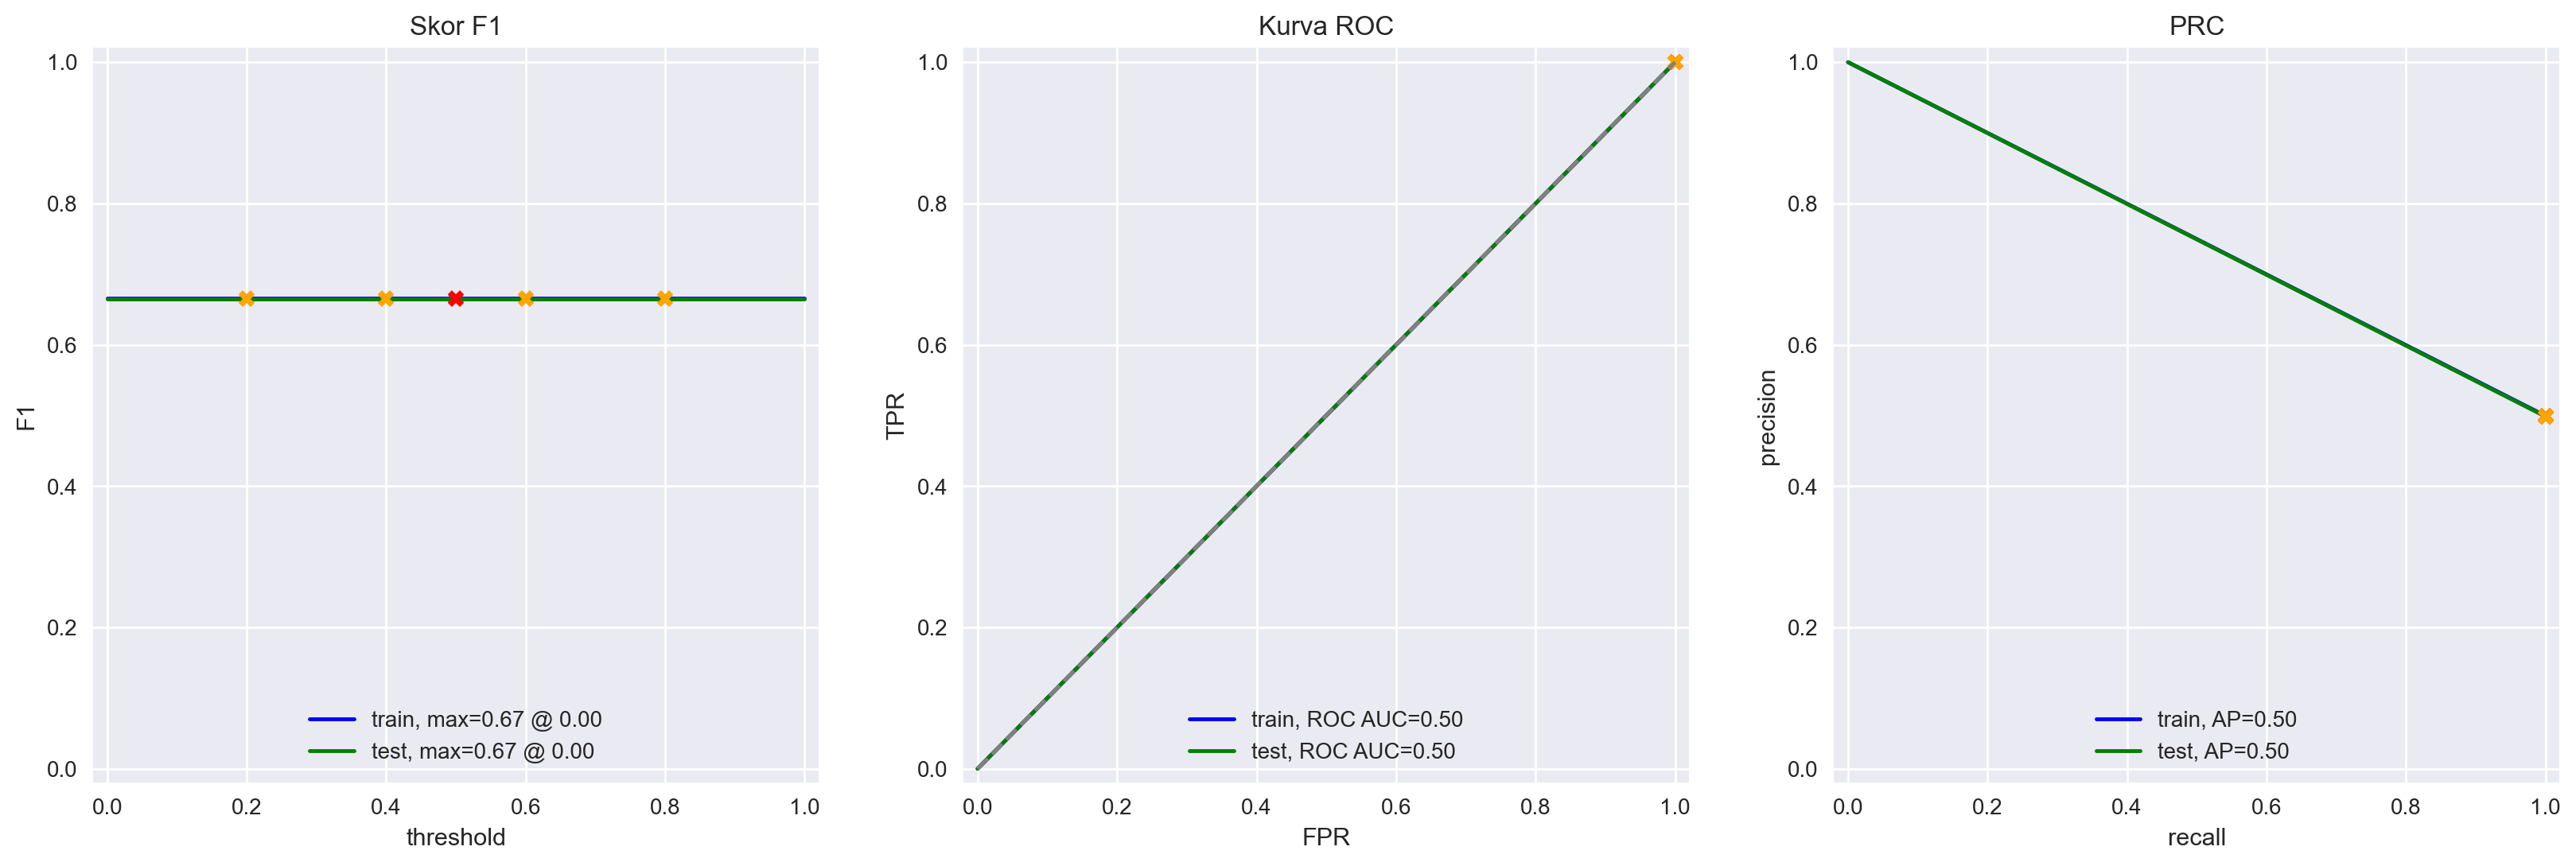

In [24]:
evaluate_model(model_0, np.zeros(len(train_target)), train_target, np.zeros(len(test_target)), test_target)

[back to table of contents](#back)

### 6.2. NLTK LR <a id='62'></a>

#### Initiation

Lemmatize words:

In [25]:
def nltk_lemmatize(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = nltk.tokenize.word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    sent_lemmas = (' '.join(lemmas))  
    return sent_lemmas

In [26]:
train_corpus_1 = df_reviews_train['review'].progress_apply(nltk_lemmatize)
test_corpus_1 = df_reviews_test['review'].progress_apply(nltk_lemmatize)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

Download stopwords:

In [27]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anglo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### BOW

In [28]:
count_vect_1a = CountVectorizer(stop_words=stop_words)
train_features_1a = count_vect_1a.fit_transform(train_corpus_1)
test_features_1a = count_vect_1a.transform(test_corpus_1)

In [29]:
model_1a = LogisticRegression()
    
with tqdm(total=1, desc="Fitting model") as pbar:
    model_1a.fit(train_features_1a, train_target)
    pbar.update(1)

Fitting model:   0%|          | 0/1 [00:00<?, ?it/s]

         train  test
Akurasi    1.0  0.86
F1         1.0  0.86
APS        1.0  0.93
ROC AUC    1.0  0.93


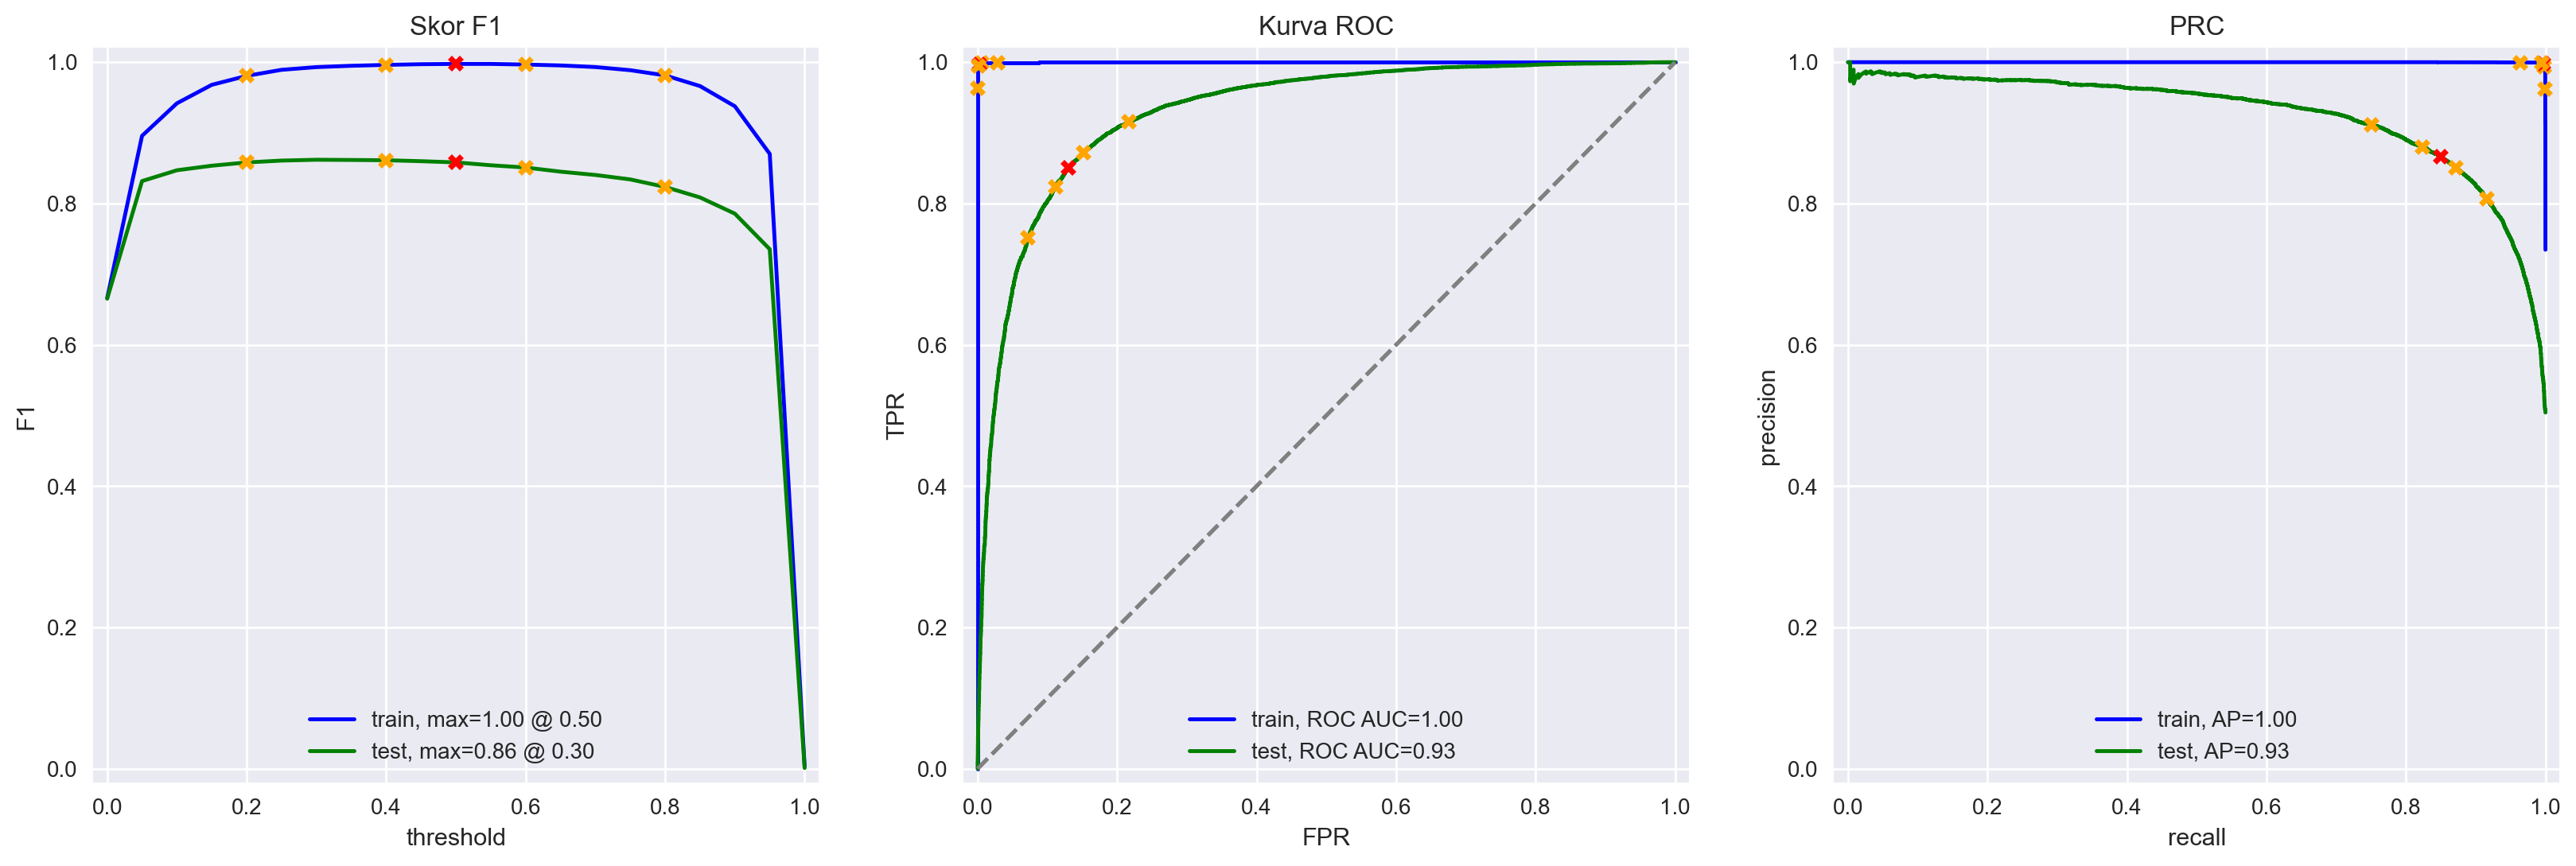

In [30]:
evaluate_model(model_1a, train_features_1a, train_target, test_features_1a, test_target)

#### BOW with N-Grams

In [31]:
count_vect_1b = CountVectorizer(stop_words=stop_words, ngram_range=(2, 3))
train_features_1b = count_vect_1b.fit_transform(train_corpus_1)
test_features_1b = count_vect_1b.transform(test_corpus_1)

In [32]:
model_1b = LogisticRegression()
model_1b.fit(train_features_1b, train_target)

LogisticRegression()

         train  test
Akurasi    1.0  0.84
F1         1.0  0.84
APS        1.0  0.91
ROC AUC    1.0  0.91


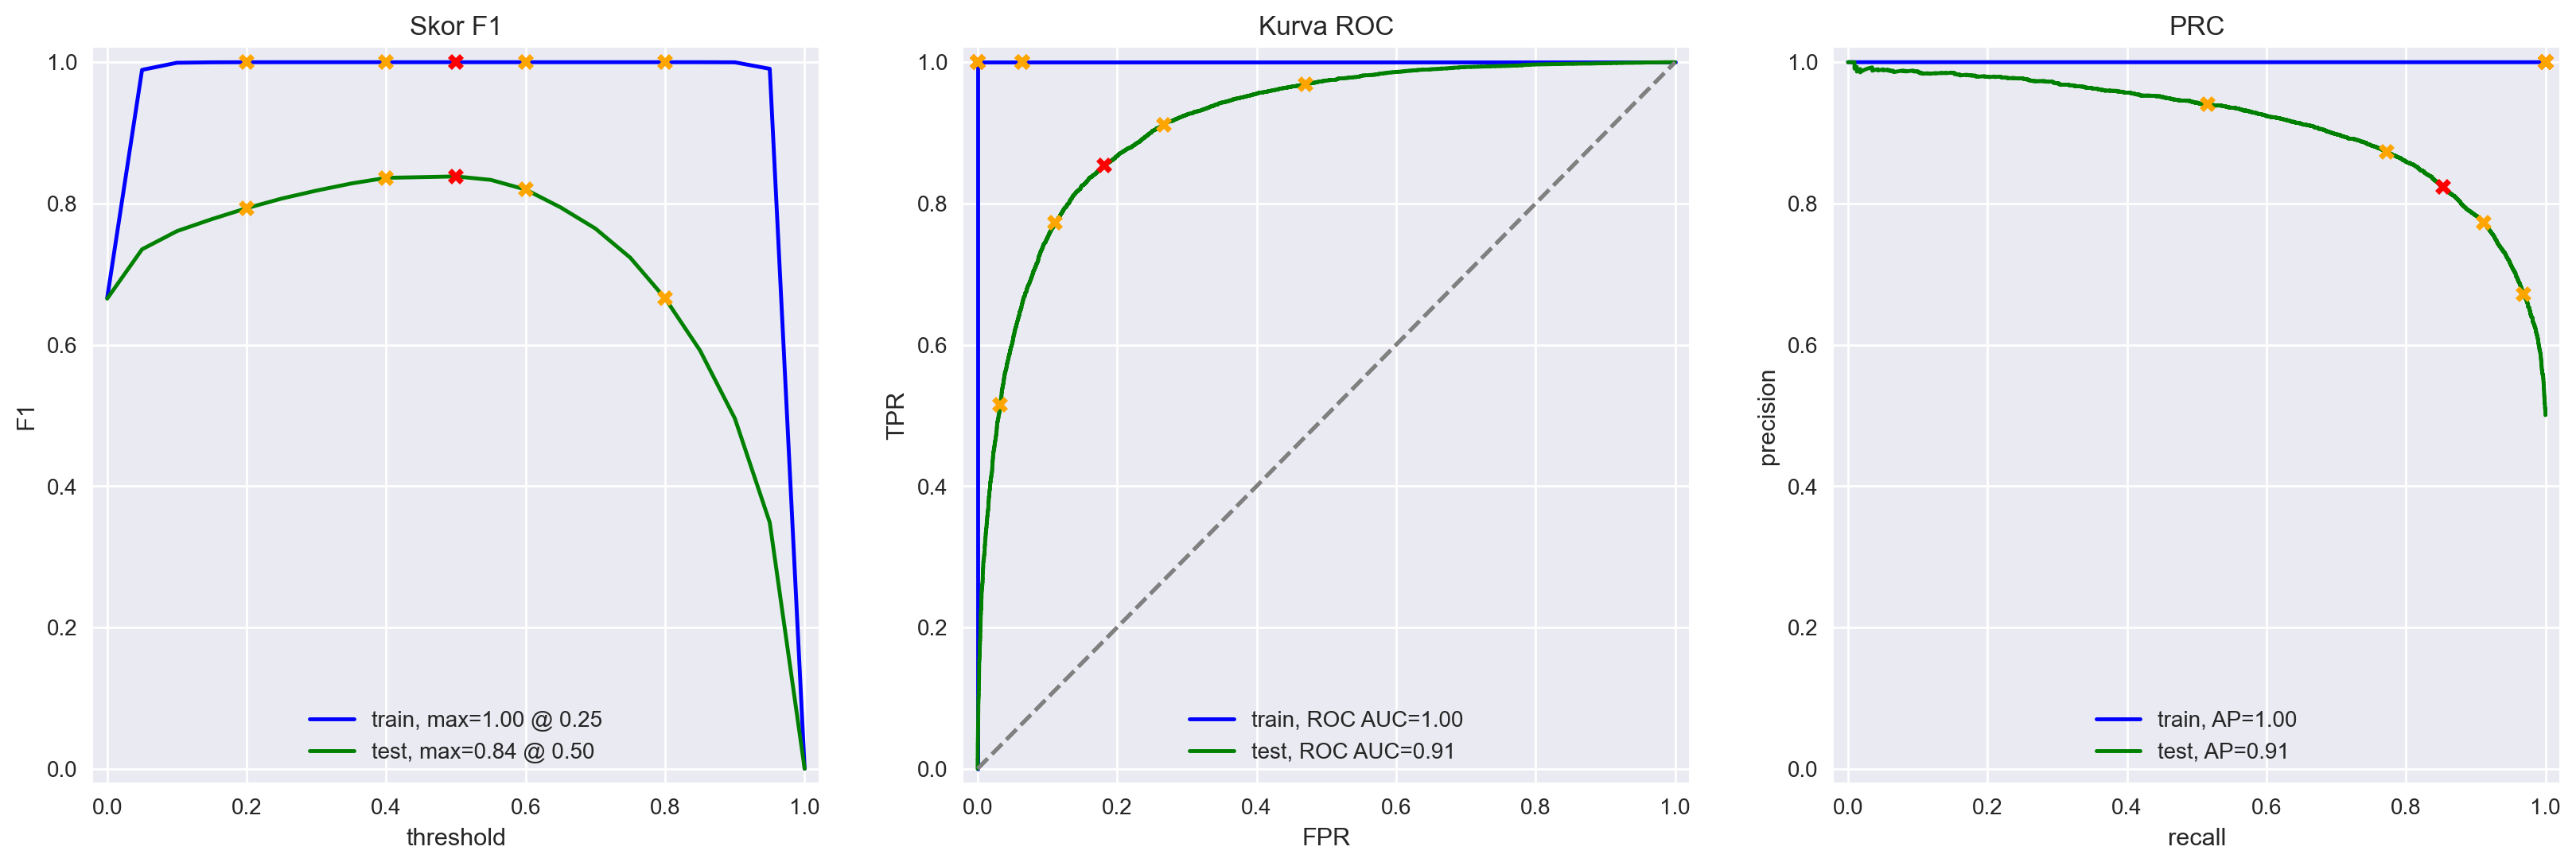

In [33]:
evaluate_model(model_1b, train_features_1b, train_target, test_features_1b, test_target)

#### TF-IDF

In [34]:
tfidf_vect_1c = TfidfVectorizer(stop_words=stop_words)
train_features_1c = tfidf_vect_1c.fit_transform(train_corpus_1)
test_features_1c = tfidf_vect_1c.transform(test_corpus_1)

In [35]:
model_1c = LogisticRegression()
model_1c.fit(train_features_1c, train_target)

LogisticRegression()

         train  test
Akurasi   0.94  0.88
F1        0.94  0.88
APS       0.98  0.95
ROC AUC   0.98  0.95


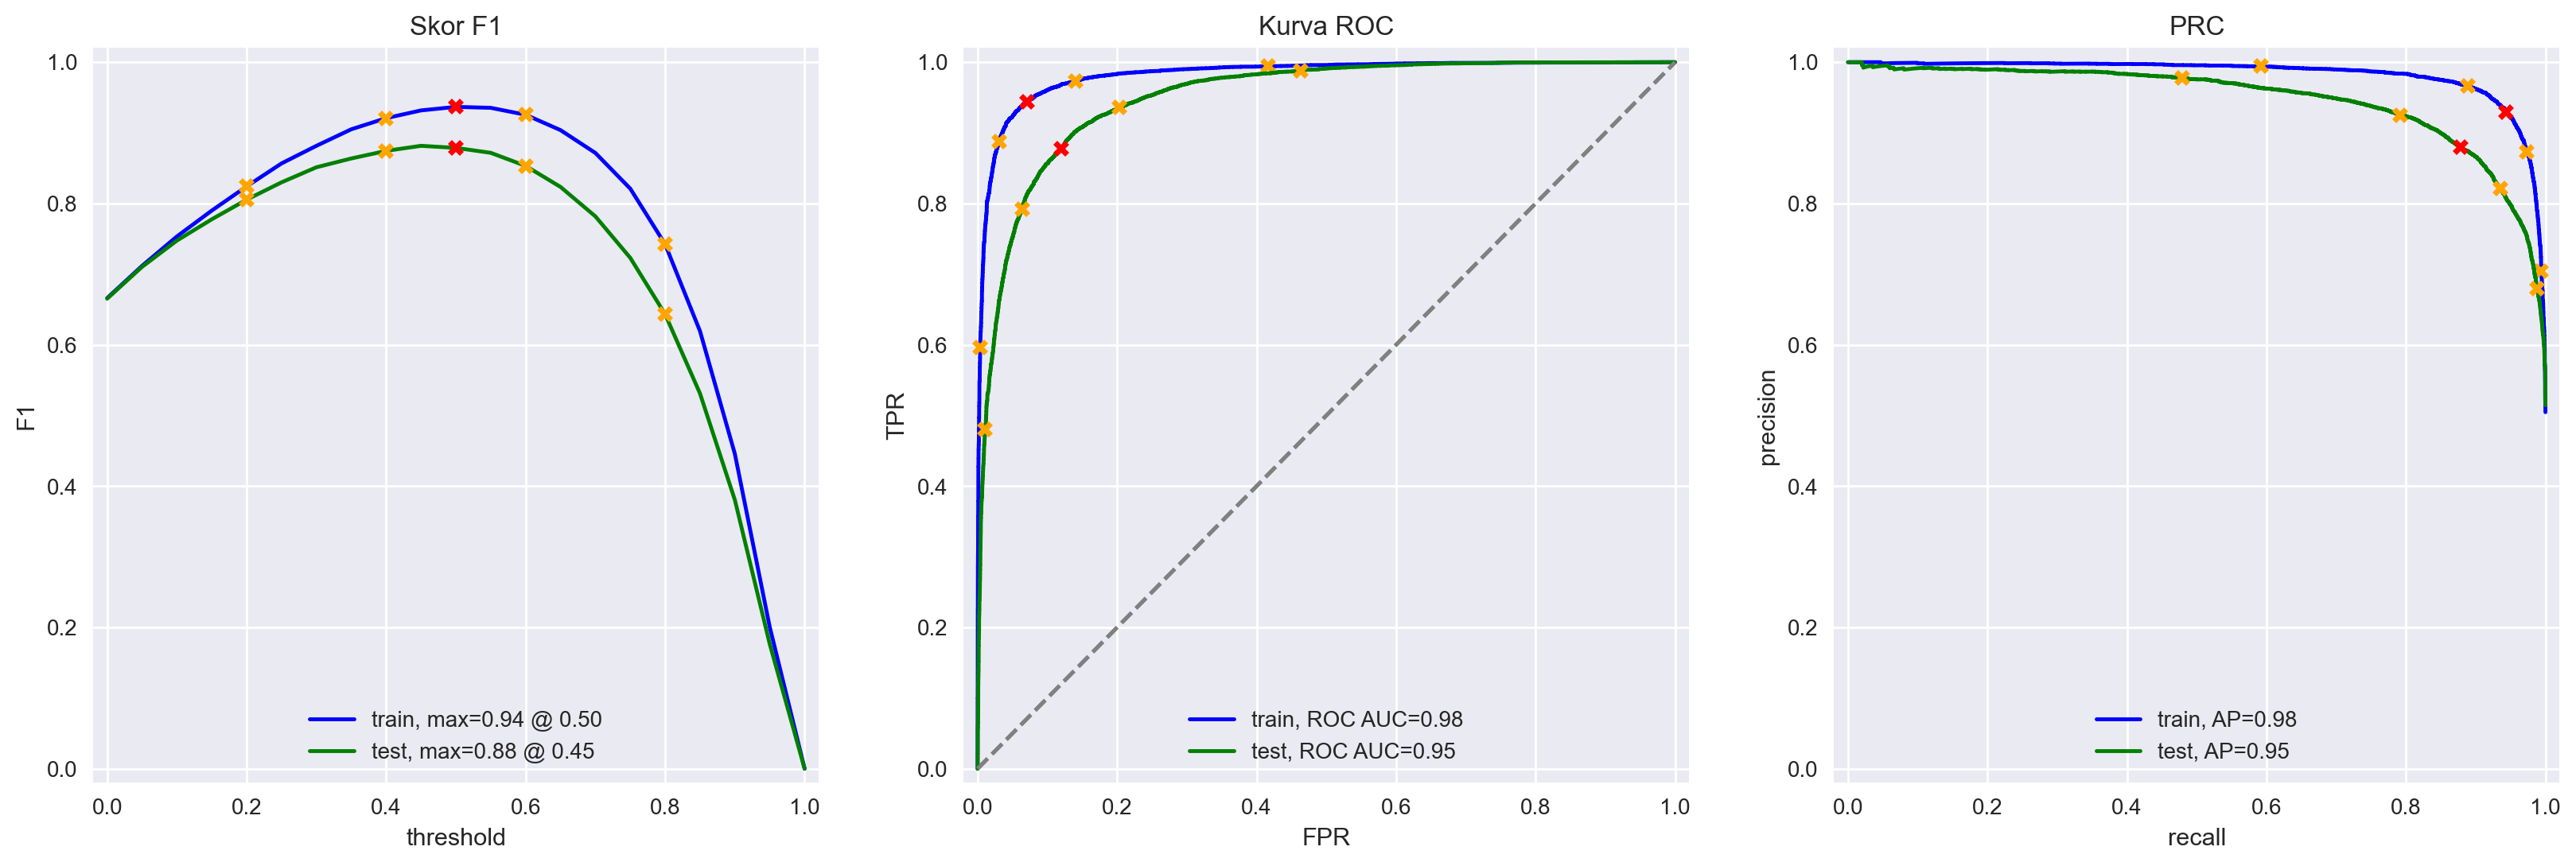

In [36]:
evaluate_model(model_1c, train_features_1c, train_target, test_features_1c, test_target)

[back to table of contents](#back)

### 6.3. spaCy

#### Initiation

In [37]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def spacy_lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    sent_lemmas = (' '.join(lemmas))  
    return sent_lemmas

In [39]:
train_corpus_2 = df_reviews_train['review'].progress_apply(spacy_lemmatize)
test_corpus_2 = df_reviews_test['review'].progress_apply(spacy_lemmatize)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

#### TF-IDF

In [40]:
tfidf_vect_2c = TfidfVectorizer(stop_words=stop_words)
train_features_2c = tfidf_vect_2c.fit_transform(train_corpus_2)
test_features_2c = tfidf_vect_2c.transform(test_corpus_2)

##### Logistic Regression

In [41]:
model_2c1 = LogisticRegression()
model_2c1.fit(train_features_2c, train_target)

LogisticRegression()

         train  test
Akurasi   0.93  0.88
F1        0.93  0.88
APS       0.98  0.94
ROC AUC   0.98  0.95


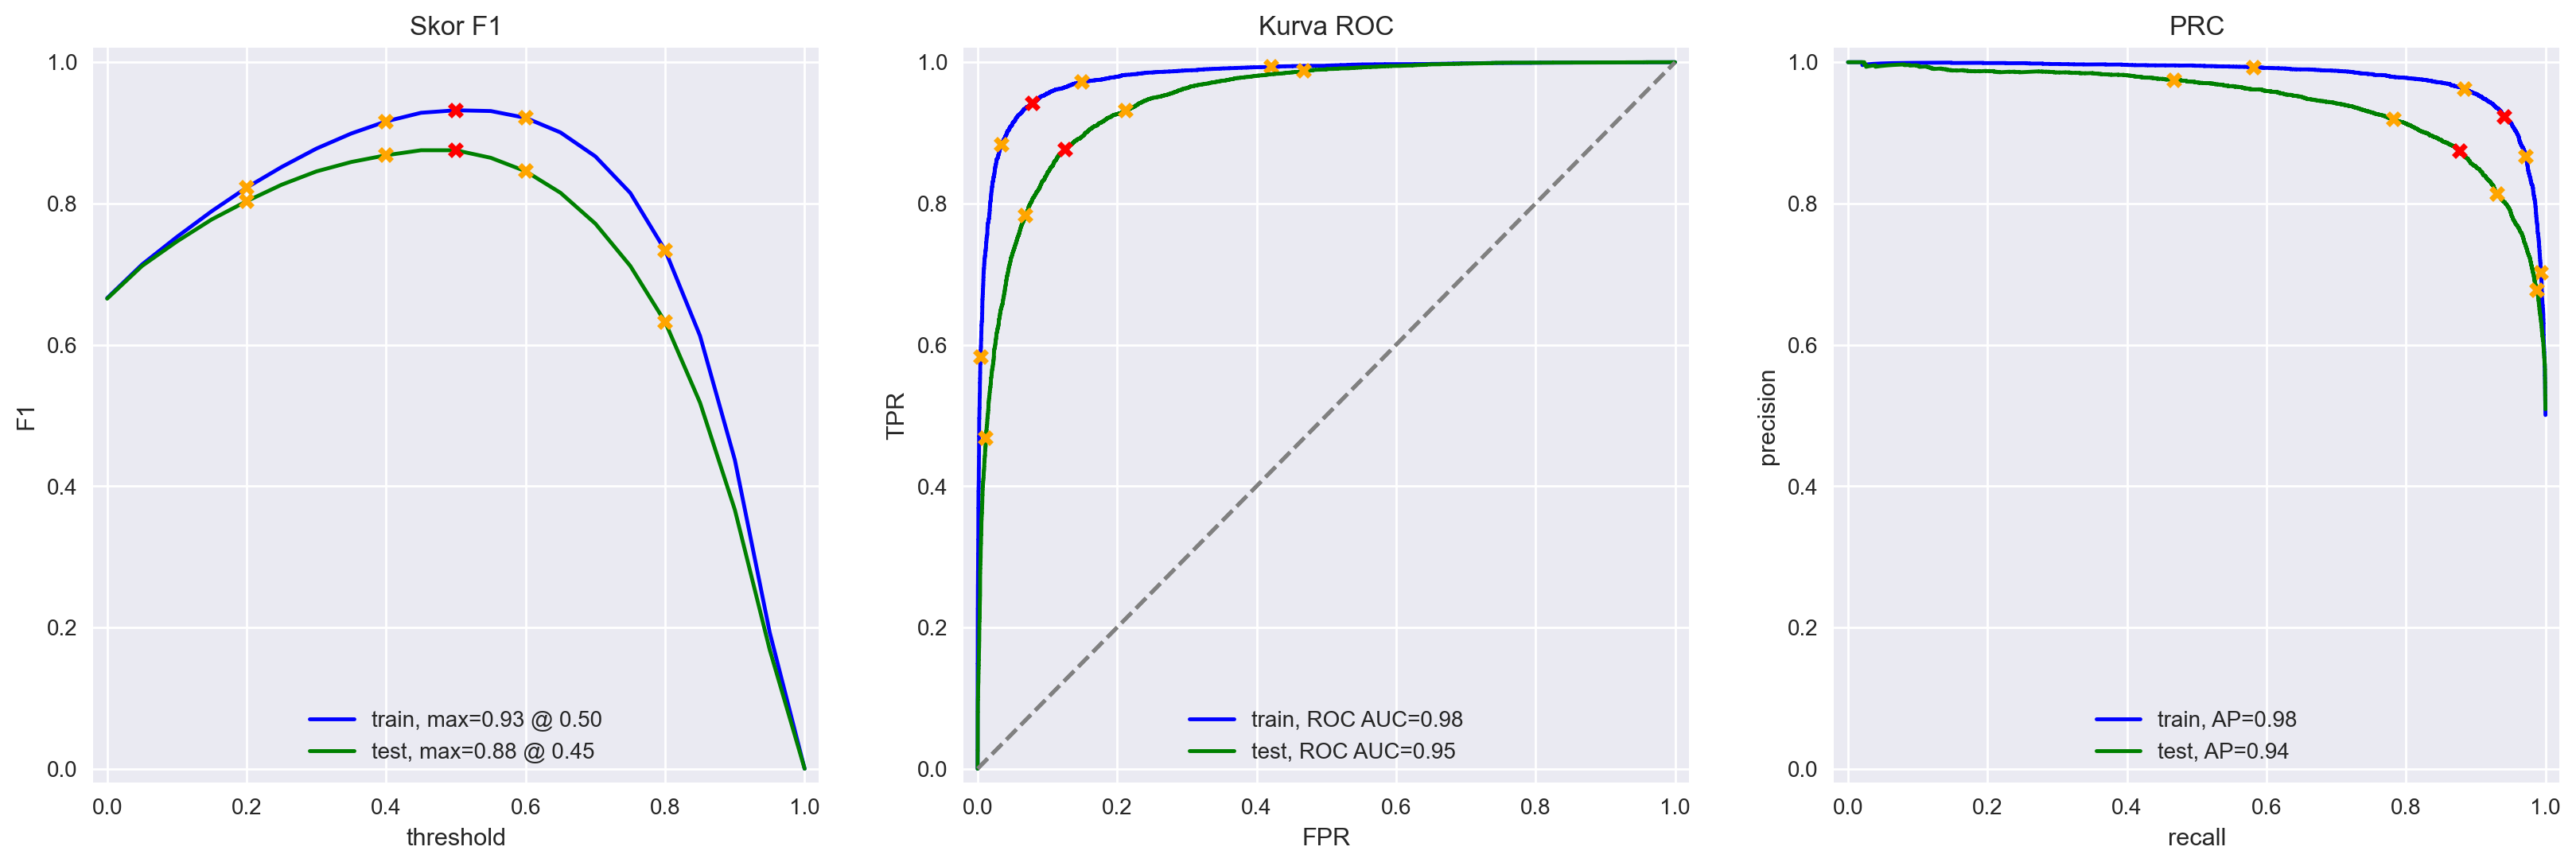

In [42]:
evaluate_model(model_2c1, train_features_2c, train_target, test_features_2c, test_target)

##### LGBM Regressor

In [43]:
model_2c2 = LGBMClassifier(random_state=1, learning_rate=0.1)
model_2c2.fit(train_features_2c, train_target)

LGBMClassifier(random_state=1)

         train  test
Akurasi   0.91  0.85
F1        0.91  0.85
APS       0.97  0.93
ROC AUC   0.97  0.93


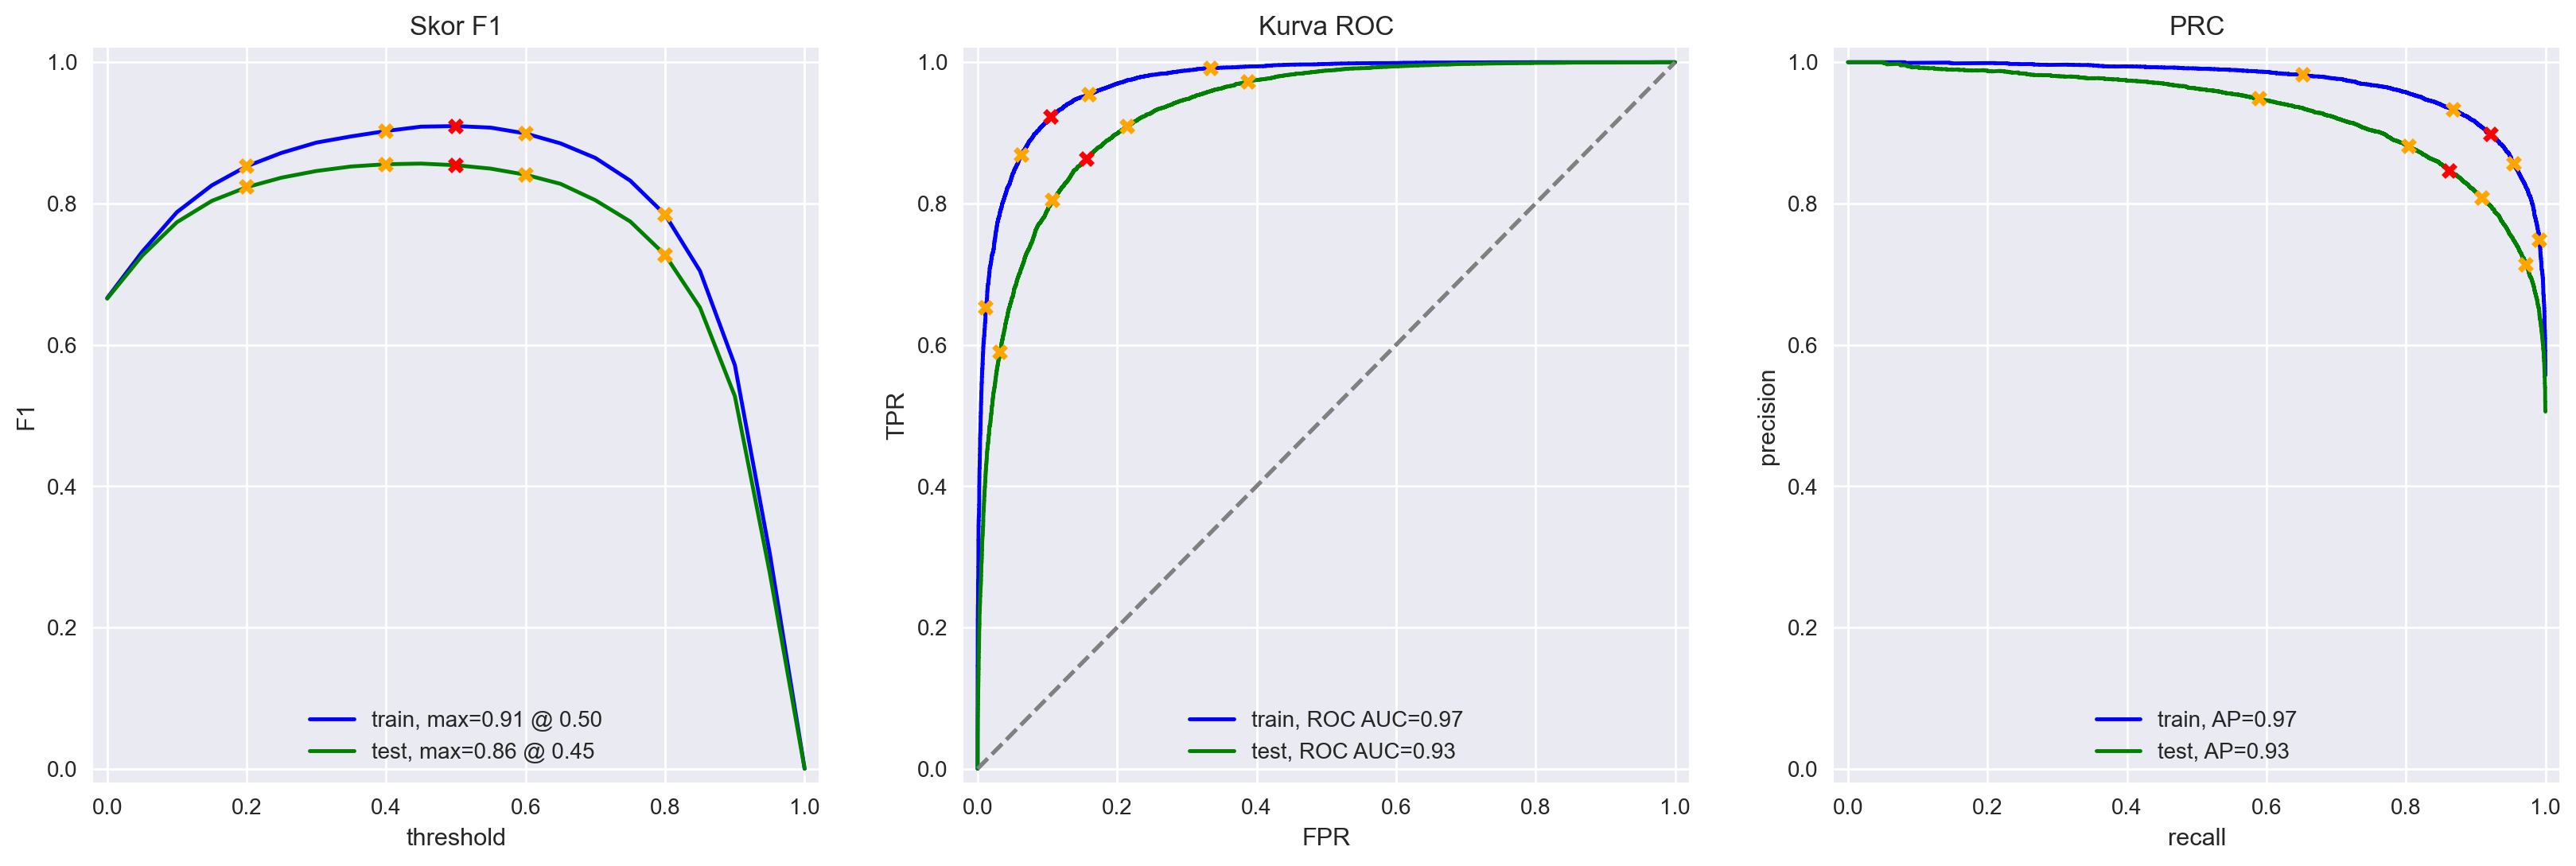

In [44]:
evaluate_model(model_2c2, train_features_2c, train_target, test_features_2c, test_target)

[back to table of contents](#back)

###  6.4. BERT <a id='64'></a>

In [45]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # convert text to padded id token and attention mask 
    
    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Use {device} device.')
    
    # get embeddings in text

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [47]:
train_index = np.random.randint(0,len(df_reviews_train),size=500)
test_index = np.random.randint(0,len(df_reviews_test),size=500)

In [48]:
# Attention! Running BERT with lots of text takes a lot of time.
train_features_3 = BERT_text_to_embeddings(df_reviews_train[df_reviews_train.index.isin(train_index)]['review_norm'])
test_features_3 = BERT_text_to_embeddings(df_reviews_test[df_reviews_test.index.isin(test_index)]['review_norm'])

train_target_3 = train_target[train_target.index.isin(train_index)]
test_target_3 = test_target[test_target.index.isin(test_index)]

  0%|          | 0/237 [00:00<?, ?it/s]

Use cpu device.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Use cpu device.


  0%|          | 0/3 [00:00<?, ?it/s]

In [49]:
print(df_reviews_train['review_norm'].shape)
print(train_features_3.shape)
print(train_target.shape)

(23796,)
(237, 768)
(23796,)


In [50]:
print(df_reviews_test['review_norm'].shape)
print(test_features_3.shape)
print(test_target.shape)

(23535,)
(244, 768)
(23535,)


#### Logistic Regression

In [51]:
model_3a = LogisticRegression()
model_3a.fit(train_features_3, train_target_3)

LogisticRegression()

         train  test
Akurasi    1.0  0.78
F1         1.0  0.76
APS        1.0  0.84
ROC AUC    1.0  0.87


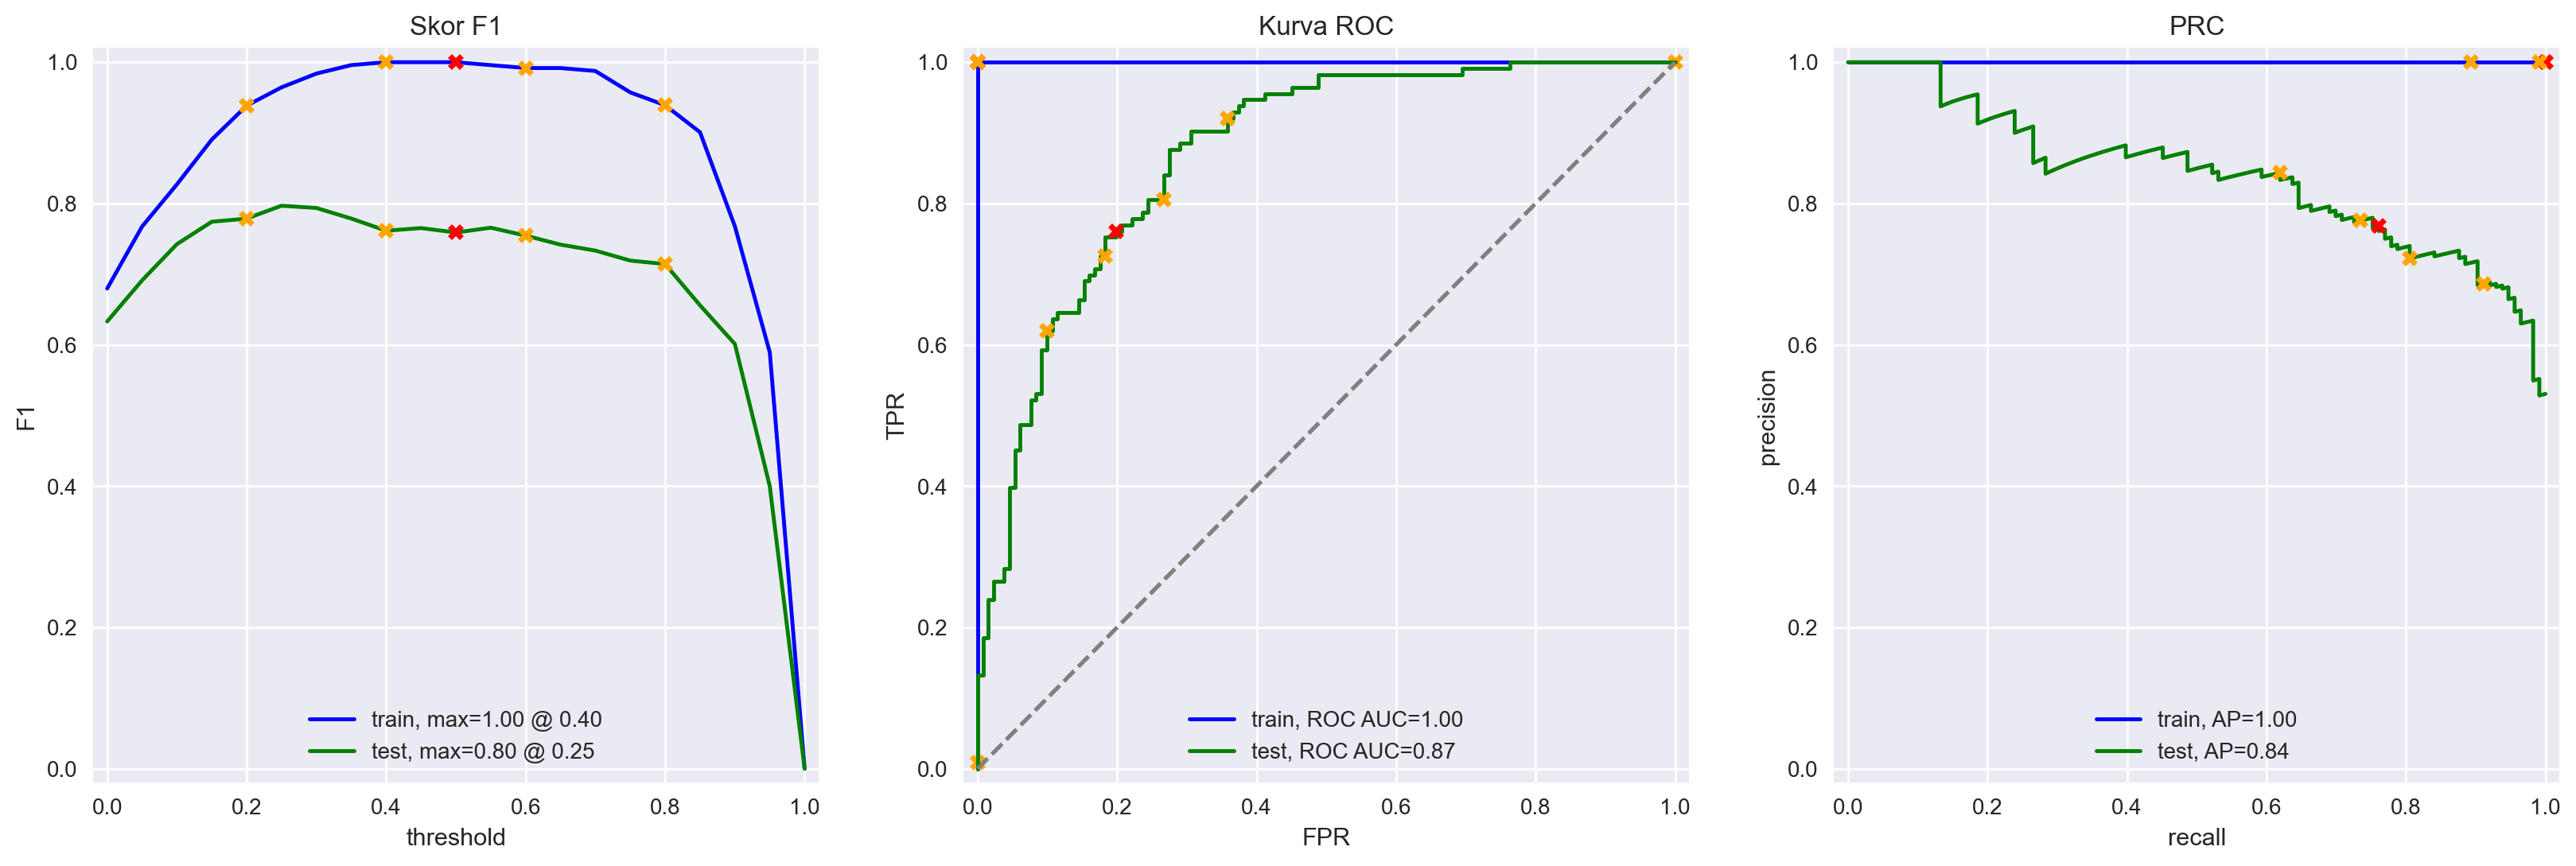

In [52]:
evaluate_model(model_3a, train_features_3, train_target_3, test_features_3, test_target_3)

#### LGBM Regressor

In [54]:
model_3b = LGBMClassifier(random_state=1, learning_rate=0.1)
model_3b.fit(train_features_3, train_target_3)

LGBMClassifier(random_state=1)

         train  test
Akurasi    1.0  0.74
F1         1.0  0.72
APS        1.0  0.81
ROC AUC    1.0  0.82


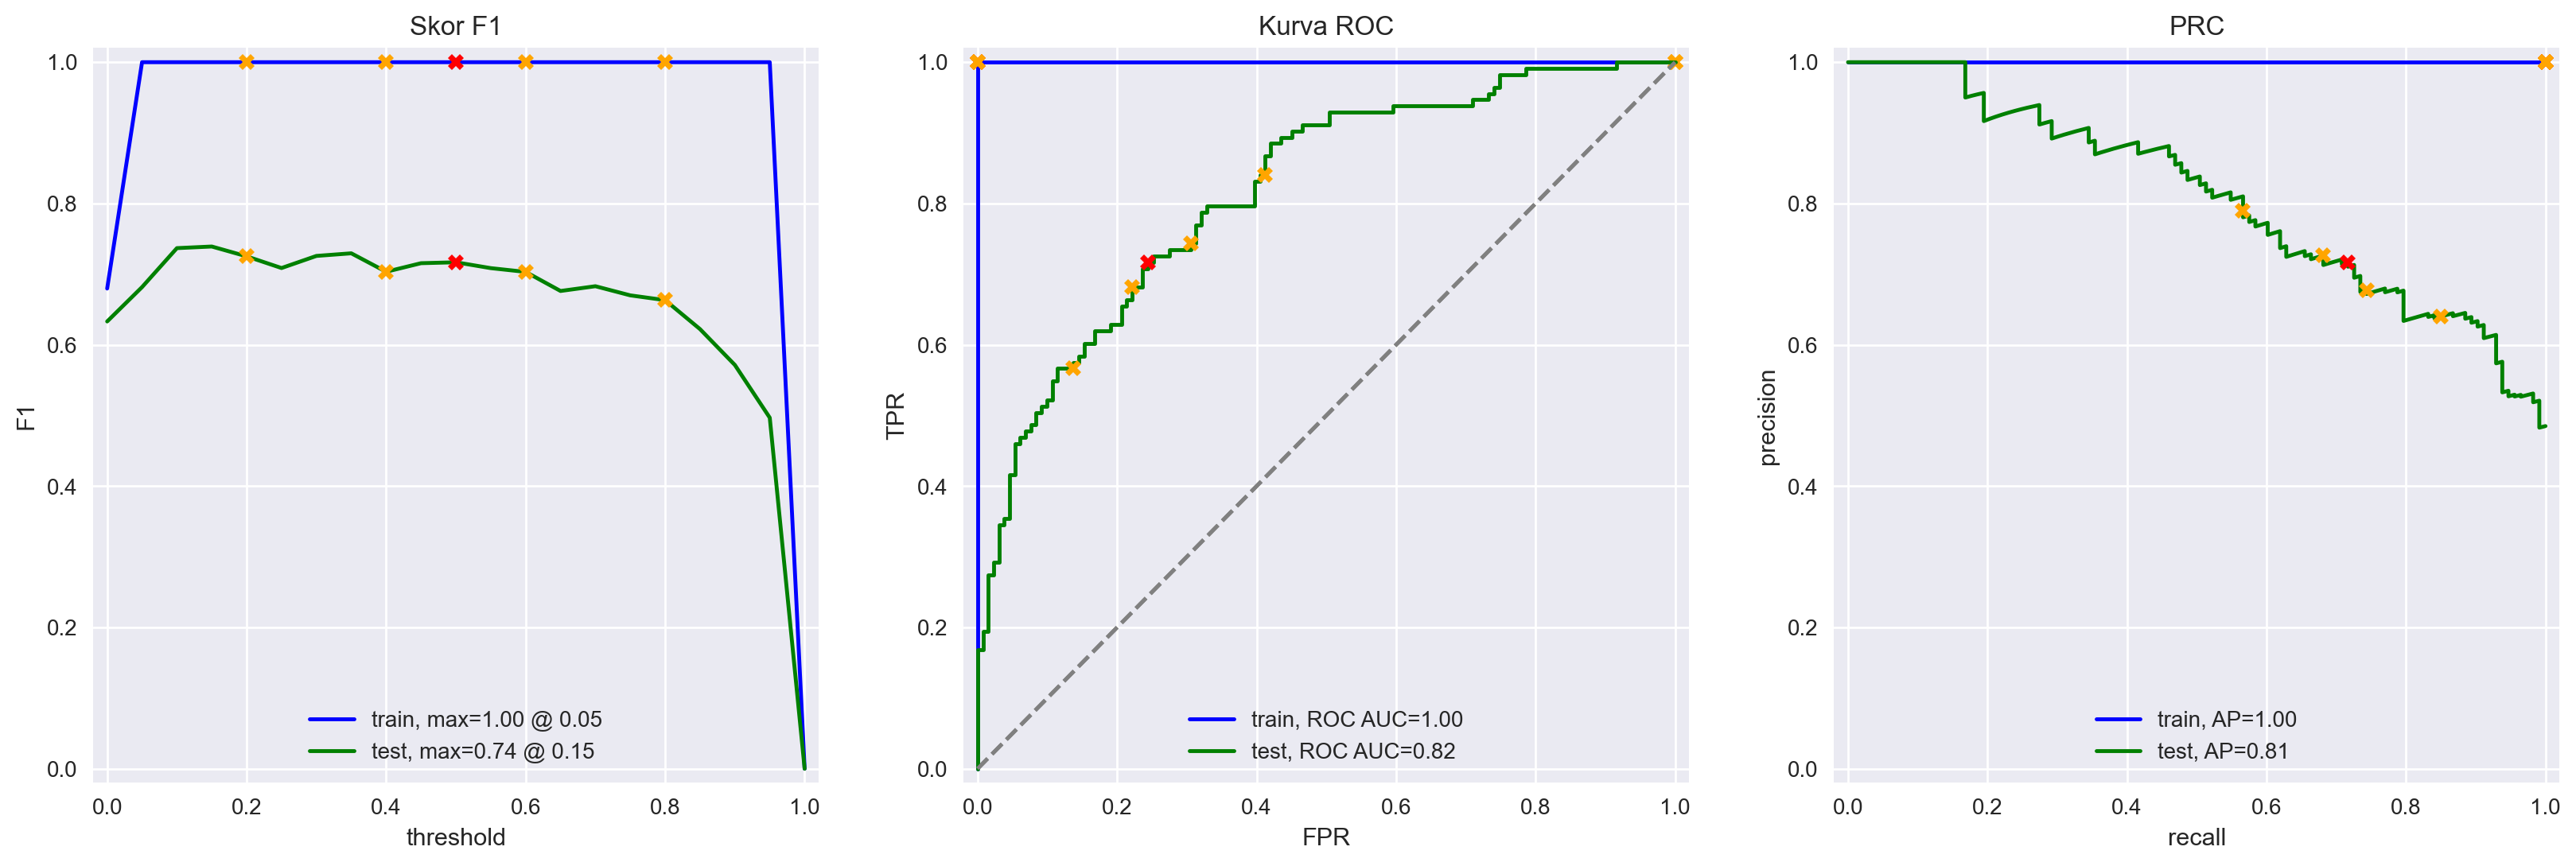

In [55]:
evaluate_model(model_3b, train_features_3, train_target_3, test_features_3, test_target_3)

In [56]:
# save embeddings for immediate load
# np.savez_compressed('features_3.npz', train_features_3=train_features_3, test_features_3=test_features_3)

# load
# with np.load('features_3.npz') as data:
#     train_features_3 = data['train_features_3']
#     test_features_3 = data['test_features_3']

[back to table of contents](#back)

## 7. Model Review <a id='eval'></a>

In [61]:
my_reviews = pd.DataFrame([
    "I don't really like it, it's not my type of favorite movie.",
    "Boring, I even fell asleep in the middle of the movie.",
    "The movie is really good, I really like it.",
    "Even the actors look very old and uninterested in the movie, are they paid to act in the movie? It's really low quality.",
    "I didn't expect the movie to be this good! The writer really pays attention to every detail.",
    "This movie has its strengths and weaknesses, but overall I think it's a decent movie. I might watch it again.",
    "Some of the jokes are not funny at all. Not a single joke works, everyone is acting annoying, even children wouldn't like it!",
    "Showing the movie on Netflix is a brave move and I'm very happy to be able to watch episode by episode of this new and smartly interesting drama."
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower()
my_reviews['review_norm'] = my_reviews['review_norm'].progress_apply(clear_text)

my_reviews

  0%|          | 0/8 [00:00<?, ?it/s]

,review,review_norm
0,"I don't really like it, it's not my type of fa...",i don t really like it it s not my type of fav...
1,"Boring, I even fell asleep in the middle of th...",boring i even fell asleep in the middle of the...
2,"The movie is really good, I really like it.",the movie is really good i really like it
3,Even the actors look very old and uninterested...,even the actors look very old and uninterested...
4,I didn't expect the movie to be this good! The...,i didn t expect the movie to be this good the ...
5,"This movie has its strengths and weaknesses, b...",this movie has its strengths and weaknesses bu...
6,Some of the jokes are not funny at all. Not a ...,some of the jokes are not funny at all not a s...
7,Showing the movie on Netflix is a brave move a...,showing the movie on netflix is a brave move a...


### 7.1. Model 1c - NLTK TF-IDF LR <a id='71'></a>

In [62]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1c.predict_proba(tfidf_vect_1c.transform(my_reviews['review_norm'].apply(lambda x: nltk_lemmatize(x))))[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.92:  i don t really like it it s not my type of favorite movie
0.01:  boring i even fell asleep in the middle of the movie
0.59:  the movie is really good i really like it
0.05:  even the actors look very old and uninterested in the movie are they paid to act in the movie it s r
0.56:  i didn t expect the movie to be this good the writer really pays attention to every detail
0.66:  this movie has its strengths and weaknesses but overall i think it s a decent movie i might watch it
0.05:  some of the jokes are not funny at all not a single joke works everyone is acting annoying even chil
0.86:  showing the movie on netflix is a brave move and i m very happy to be able to watch episode by episo


[back to table of contents](#back)

### 7.2. Model 2c1 - spaCy TF-IDF LR <a id='72'></a>

In [63]:
my_reviews_pred_prob = model_2c1.predict_proba(tfidf_vect_2c.transform(my_reviews['review_norm'].apply(lambda x: spacy_lemmatize(x))))[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.95:  i don t really like it it s not my type of favorite movie
0.06:  boring i even fell asleep in the middle of the movie
0.92:  the movie is really good i really like it
0.08:  even the actors look very old and uninterested in the movie are they paid to act in the movie it s r
0.56:  i didn t expect the movie to be this good the writer really pays attention to every detail
0.65:  this movie has its strengths and weaknesses but overall i think it s a decent movie i might watch it
0.04:  some of the jokes are not funny at all not a single joke works everyone is acting annoying even chil
0.89:  showing the movie on netflix is a brave move and i m very happy to be able to watch episode by episo


[back to table of contents](#back)

### 7.3. Model 2c2 - spaCy TF-IDF LGBMRegressor <a id='73'></a>

In [64]:
my_reviews_pred_prob = model_2c2.predict_proba(tfidf_vect_2c.transform(my_reviews['review_norm'].apply(lambda x: spacy_lemmatize(x))))[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.82:  i don t really like it it s not my type of favorite movie
0.37:  boring i even fell asleep in the middle of the movie
0.80:  the movie is really good i really like it
0.39:  even the actors look very old and uninterested in the movie are they paid to act in the movie it s r
0.73:  i didn t expect the movie to be this good the writer really pays attention to every detail
0.56:  this movie has its strengths and weaknesses but overall i think it s a decent movie i might watch it
0.33:  some of the jokes are not funny at all not a single joke works everyone is acting annoying even chil
0.71:  showing the movie on netflix is a brave move and i m very happy to be able to watch episode by episo


[back to table of contents](#back)

### 7.4. Model 3a - BERT LR <a id='74'></a>

In [65]:
my_reviews_features_3 = BERT_text_to_embeddings(my_reviews['review_norm'], disable_progress_bar=True)

my_reviews_pred_prob = model_3a.predict_proba(my_reviews_features_3)[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.11:  i don t really like it it s not my type of favorite movie
0.03:  boring i even fell asleep in the middle of the movie
0.86:  the movie is really good i really like it
0.00:  even the actors look very old and uninterested in the movie are they paid to act in the movie it s r
0.12:  i didn t expect the movie to be this good the writer really pays attention to every detail
0.37:  this movie has its strengths and weaknesses but overall i think it s a decent movie i might watch it
0.01:  some of the jokes are not funny at all not a single joke works everyone is acting annoying even chil
0.82:  showing the movie on netflix is a brave move and i m very happy to be able to watch episode by episo


[back to table of contents](#back)

## 8. General Conclusion

In the initial data validation, it is found that there are no duplicates. There are only two NaN values and there are some missing values are stored as '\N' because there are no data regarding those columns.
From EDA, I found out that the number of movies is increasing steadily over the years until 2006 when it reaches around 380 movies then it drops afterwards. The number of positive and negative reviews are also increasing in the same trend. In addition, the number of reviews per movie distribution decrease exponentially except for 30 reviews per movie. The target classes are well-balanced, with an almost 50/50 distribution. The distribution of positive and negative reviews are similar in both train and test set. It is most frequent to see about 1 negative review and 4 positive reviews in a movie.
The reviews were then normalized by removing space, digits, punctuations, etc and put into lowercase.
From the model training, I found out that
* NLTK, TF-IDF, LR achieved an F1 score of 0.94 (train) and 0.88 (test).
* Spacy, TF-IDF, LR achieved an F1 score of 0.93 (train) and 0.88 (test).
* Spacy, TF-IDF, LGBM achieved an F1 score of 0.91 (train) and 0.85 (test).
* BERT, LR obtained an F1 score of 1.0 (train) and 0.78 (test).

BERT was the only model that **didn't** reach a minimum F1 score of 0.85 during the testing phase. However, this can be attributed to the fact that my BERT model was trained on only a subset of 500 samples due to hardware limitations (working on CPU). I am confident that training the model on the entire dataset will surpass the threshold, and this model has the potential to achieve even better results compared to the others.

[back to table of contents](#back)